## Reading Data from HDFS

Datasource: Semantic Scholar Open Research Corpus

Description: Semantic Scholar's records for research papers published in all fields provided as an easy-to-use JSON archive.

### Attribute Definitions
1. id  string = S2 generated research paper ID.
- title  string = Research paper title.
- paperAbstract  string = Extracted abstract of the paper.
- entities  list = Extracted list of relevant entities or topics.
- s2Url  string = URL to S2 research paper details page.
- s2PdfUrl  string = URL to PDF on S2 if available.
- pdfUrls  list = URLs related to this PDF scraped from the web.
- authors  list = List of authors with an S2 generated author ID and name.
- inCitations  list = List of S2 paper IDs which cited this paper.
- outCitations  list = List of S2 paper IDs which this paper cited
- year  int = Year this paper was published as integer.
- venue  string = Extracted publication venue for this paper.
- journalName  string = Name of the journal that published this paper.
- journalVolume  string = The volume of the journal where this paper was published.
- journalPages  string = The pages of the journal where this paper was published.
- sources  list = Identifies papers sourced from DBLP or Medline.
- doi  string = Digital Object Identifier registered at doi.org.
- doiUrl  string = DOI link for registered objects.
- pmid  string = Unique identifier used by PubMed.
- fieldsOfStudy  list = Zero or more fields of study this paper addresses.`

In [1]:
import pandas as pd 
import json
import matplotlib.pyplot as plt 

#Graph network imports
from graphframes import *
from pyspark import *
from pyspark.sql import *
import numpy as np
from pyspark.ml.linalg import *
from pyspark.ml.linalg import *
from pyspark.sql.types import * 
from pyspark.sql.functions import *

from pyspark.sql.functions import udf #user defined function
from pyspark.sql.types import * #Import types == IntegerType, StringType etc.

import nltk

In [2]:
#import statements
from pyspark.sql import SparkSession

#create Spark session
spark = SparkSession.builder.enableHiveSupport().appName('Final_project_read_write').getOrCreate()

conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '15g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '10'), ('spark.cores.max', '10'), ('spark.driver.memory','20g')])

#print spark configuration settings
#spark.sparkContext.getConf().getAll()

In [3]:
!hdfs dfs -ls big_data_project/unzipped_files/

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
Found 10 items
-rw-r--r--   3 nazihkalo nazihkalo 1592749572 2020-02-11 10:25 big_data_project/unzipped_files/s2-corpus-000
-rw-r--r--   3 nazihkalo nazihkalo 1592820732 2020-02-11 10:24 big_data_project/unzipped_files/s2-corpus-001
-rw-r--r--   3 nazihkalo nazihkalo 1595233436 2020-02-11 10:24 big_data_project/unzipped_files/s2-corpus-002
-rw-r--r--   3 nazihkalo nazihkalo 1597066383 2020-02-11 10:24 big_data_project/unzipped_files/s2-corpus-003
-rw-r--r--   3 nazihkalo nazihkalo 1601510198 2020-02-11 10:24 big_data_project/unzipped_files/s2-corpus-004
-rw-r--r--   3 nazihkalo nazihkalo 1593588156 2020-02-11 10:25 big_data_project/unzipped_files/s2-corpus-005
-rw-r--r--   3 nazihkalo nazihkalo 1596634329 2020-02-11 10:23 big_data_project/unzipped_files/s2-corpus-006
-rw-r--r--   3 nazihkalo nazihkalo 1596512143 2020-02-11 10:25 big_data_project/unzipped_files/s2-corpus-007
-rw-r--r-

In [4]:
sc.environment

{'MKL_NUM_THREADS': '1', 'OPENBLAS_NUM_THREADS': '1', 'PYTHONHASHSEED': '0'}

## Reading all 10 json files listed above 

In [5]:
spark_df = spark.read.json('big_data_project/unzipped_files/')

#### Counting number of records/articles

In [6]:
spark_df.count()

9976989

#### Looking at the schema & summary stats

In [7]:
spark_df.printSchema()

root
 |-- authors: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- ids: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- doiUrl: string (nullable = true)
 |-- entities: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- fieldsOfStudy: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- inCitations: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- journalName: string (nullable = true)
 |-- journalPages: string (nullable = true)
 |-- journalVolume: string (nullable = true)
 |-- outCitations: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- paperAbstract: string (nullable = true)
 |-- pdfUrls: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- pmid: string (nullable = t

In [8]:
spark_df.dtypes

[('authors', 'array<struct<ids:array<string>,name:string>>'),
 ('doi', 'string'),
 ('doiUrl', 'string'),
 ('entities', 'array<string>'),
 ('fieldsOfStudy', 'array<string>'),
 ('id', 'string'),
 ('inCitations', 'array<string>'),
 ('journalName', 'string'),
 ('journalPages', 'string'),
 ('journalVolume', 'string'),
 ('outCitations', 'array<string>'),
 ('paperAbstract', 'string'),
 ('pdfUrls', 'array<string>'),
 ('pmid', 'string'),
 ('s2PdfUrl', 'string'),
 ('s2Url', 'string'),
 ('sources', 'array<string>'),
 ('title', 'string'),
 ('venue', 'string'),
 ('year', 'bigint')]

In [11]:
spark_df.show(5)

+--------------------+--------------------+--------------------+--------+-------------------+--------------------+--------------------+-----------+------------+-------------+--------------------+--------------------+--------------------+--------+--------+--------------------+---------+--------------------+--------+----+
|             authors|                 doi|              doiUrl|entities|      fieldsOfStudy|                  id|         inCitations|journalName|journalPages|journalVolume|        outCitations|       paperAbstract|             pdfUrls|    pmid|s2PdfUrl|               s2Url|  sources|               title|   venue|year|
+--------------------+--------------------+--------------------+--------+-------------------+--------------------+--------------------+-----------+------------+-------------+--------------------+--------------------+--------------------+--------+--------+--------------------+---------+--------------------+--------+----+
|[[[52602509], Yan...|            

In [9]:
# spark_df.summary()

### Checking if any NaN rows 

In [12]:
spark_df.dropna().count()

9784508

In [14]:
#Calculating total number of NAN rows
row_count = spark_df.count()
null_row_count = row_count - spark_df.dropna().count()
print("Total Null rows = ", null_row_count)
print("Nulls as pct of total = {}%".format((null_row_count/row_count)*100))

Total Null rows =  192481
Nulls as pct of total = 1.92924939578464%


### Looks like all the NAs are in year, let's impute using the median year

In [6]:
#Checking where the NAs are
from pyspark.sql.functions import isnan, when, count, col
spark_df.select([count(when(col(c).isNull(), c)).alias(c) for c in spark_df.columns]).toPandas().T

,0
authors,0
doi,0
doiUrl,0
entities,0
fieldsOfStudy,0
id,0
inCitations,0
journalName,0
journalPages,0
journalVolume,0


In [7]:
#Impute median year
year_stats = spark_df.select('year').summary()
median_year = int(year_stats.collect()[5].year)
print('the median year is = ', median_year)

#Inputing the median year
modeling_data = spark_df.na.fill({'year': median_year})

#Convert to integer type column
modeling_data = spark_df.withColumn("year", spark_df["year"].cast(IntegerType()))

the median year is =  2008


In [15]:
spark_df.select('fieldsOfStudy').distinct().count()

2180

In [16]:
spark_df.groupby('fieldsOfStudy').count().sort("count").orderBy(["count"], ascending=[0]).show(20)

+-------------------+-------+
|      fieldsOfStudy|  count|
+-------------------+-------+
|         [Medicine]|1797410|
|                 []|1270796|
|        [Chemistry]| 647360|
| [Computer Science]| 605115|
|      [Engineering]| 532338|
|          [Biology]| 493352|
|          [Physics]| 456051|
|[Materials Science]| 427580|
|       [Psychology]| 354488|
|          [History]| 312121|
|        [Sociology]| 299245|
|              [Art]| 292479|
|      [Mathematics]| 269465|
|[Political Science]| 268942|
|        [Geography]| 250747|
|        [Economics]| 198698|
|[Medicine, Biology]| 189729|
|         [Business]| 184848|
|[Biology, Medicine]| 170081|
|          [Geology]| 166235|
+-------------------+-------+
only showing top 20 rows



In [8]:
spark_df.select('year').distinct().count()

86

## Creating column that counts the inCitations = how many times this paper was cited

In [9]:
from pyspark.sql.functions import udf #user defined function
from pyspark.sql.types import * #Import types == IntegerType, StringType etc.

length = udf(lambda listt: len(listt), IntegerType())

In [10]:
spark_df2 = spark_df.withColumn('inCitations_count', length(spark_df['inCitations']))

In [11]:
spark_df2.select('inCitations_count', 'inCitations').show(10)

+-----------------+--------------------+
|inCitations_count|         inCitations|
+-----------------+--------------------+
|                0|                  []|
|                0|                  []|
|                0|                  []|
|               13|[8ecaab2a03953fa5...|
|                0|                  []|
|                0|                  []|
|                0|                  []|
|                0|                  []|
|               22|[ecec08f5ca15e07d...|
|                2|[2da3df885d1f032d...|
+-----------------+--------------------+
only showing top 10 rows



## Creating column that counts the outCitations = how many other papers this paper cited

In [12]:
spark_df2 = spark_df2.withColumn('outCitations_count', length(spark_df2['outCitations']))
spark_df2.select('outCitations_count', 'outCitations').show(10)

+------------------+--------------------+
|outCitations_count|        outCitations|
+------------------+--------------------+
|                 0|                  []|
|                 0|                  []|
|                 0|                  []|
|                69|[cf5cdba6424524ee...|
|                 0|                  []|
|                 0|                  []|
|                 0|                  []|
|                 0|                  []|
|                 0|                  []|
|                 0|                  []|
+------------------+--------------------+
only showing top 10 rows



In [13]:
#Counting distinct values in each column
from pyspark.sql.functions import countDistinct, col

distinct_pdf = spark_df2.agg(*(countDistinct(col(c)).alias(c) for c in spark_df2.columns)).collect()

distinct_pdf = pd.DataFrame(pd.DataFrame(distinct_pdf, columns = spark_df2.columns).stack(0)).rename({0:'distinct_cnt'}, axis = 1)

In [14]:
distinct_pdf.sort_values('distinct_cnt')

distinct_cnt
0 entities                       1
  s2PdfUrl                       1
  sources                        5
  year                          85
  outCitations_count           678
  inCitations_count           1654
  fieldsOfStudy               2180
  journalName                50554
  venue                      61054
  journalVolume              77493
  journalPages              411597
  outCitations             1572215
  pmid                     1692355
  pdfUrls                  1783133
  inCitations              2846805
  doiUrl                   4886396
  doi                      4886420
  paperAbstract            5525030
  authors                  8375458
  title                    9915513
  s2Url                    9976989
  id                       9976989

Let's look at a sample abstract

In [24]:
spark_df2.select('paperAbstract').limit(1).collect()[0][0]

'The problem of budgetary overrun in real estate projects has been enterprises attach great importance.In this paper,we analyze the cause of budgetary overrun in real estate projects in view of building materials,equipment investment and construction;secondly,from the construction costs of the standardized management,enterprise system management and other aspects,we super effective countermeasures to control the budgetary overrun in real estate projects;finally,taking an example of a real estate project in Hunan Province,in detail we analyze the causes and control measures of budgetary overrun in real estate projects.The study can be implemented to provide guidance for similar projects.'

## Tokenize the abstract & title

In [15]:
from pyspark.sql.functions import udf, col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer

# Clean text
spark_df2 = spark_df2.withColumn('paperAbstract', (lower(regexp_replace('paperAbstract', "[^a-zA-Z\\s]", ""))))
spark_df2 = spark_df2.withColumn('title', (lower(regexp_replace('title', "[^a-zA-Z\\s]", ""))))

# word_count = udf(lambda string: len(nltk.word_tokenize(string)), IntegerType()) ## OLD SOLUTION 
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

#tokenize words
tokenizer = Tokenizer(inputCol="paperAbstract", outputCol="abstract_tokens")
spark_df2 = tokenizer.transform(spark_df2)

tokenizer = Tokenizer(inputCol="title", outputCol="title_tokens")
spark_df2 = tokenizer.transform(spark_df2)

## Remove Stopwords

In [16]:
from pyspark.ml.feature import StopWordsRemover

#remove stop words
remover = StopWordsRemover(inputCol="abstract_tokens", outputCol="abstract_tokens_filtered")
spark_df2 = remover.transform(spark_df2)

#remove stop words
remover = StopWordsRemover(inputCol="title_tokens", outputCol="title_tokens_filtered")
spark_df2 = remover.transform(spark_df2)

## Filter short words

In [17]:
# Filter length word > 3
filter_length_udf = udf(lambda row: [x for x in row if len(x) >= 3], ArrayType(StringType()))

spark_df2 = spark_df2.withColumn('abstract_tokens_filtered', filter_length_udf(col('abstract_tokens_filtered')))
spark_df2 = spark_df2.withColumn('title_tokens_filtered', filter_length_udf(col('title_tokens_filtered')))

## Lemmetize words

In [18]:
from nltk import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmatizationFunct(x):
    finalLem = [lemmatizer.lemmatize(s) for s in x]
    return finalLem

lemmetize_udf = udf(lambda tokens: lemmatizationFunct(tokens), ArrayType(StringType())) 

spark_df2 = spark_df2.withColumn('abstract_tokens_filtered_lem', lemmetize_udf(spark_df2['abstract_tokens_filtered']))
spark_df2 = spark_df2.withColumn('title_tokens_filtered_lem', lemmetize_udf(spark_df2['title_tokens_filtered']))

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/nazihkalo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Create wcount columns

In [19]:
from pyspark.sql.functions import udf 

word_count = udf(lambda tokens: len(tokens), IntegerType()) 

spark_df2 = spark_df2.withColumn('abstract_wcount', word_count(spark_df2['abstract_tokens_filtered_lem']))
spark_df2 = spark_df2.withColumn('title_wcount', word_count(spark_df2['title_tokens_filtered_lem']))

spark_df2.select('title_tokens_filtered_lem', 'title_wcount', 'abstract_tokens_filtered_lem', 'abstract_wcount').show(10)

+-------------------------+------------+----------------------------+---------------+
|title_tokens_filtered_lem|title_wcount|abstract_tokens_filtered_lem|abstract_wcount|
+-------------------------+------------+----------------------------+---------------+
|     [cause, analysis,...|           9|        [problem, budgeta...|             61|
|     [clair, comme, lu...|          14|                          []|              0|
|     [unexpected, deat...|          10|        [aim, objective, ...|            197|
|     [rnaseq, analysis...|          10|        [mitogenactivated...|            140|
|     [temporal, trend,...|          11|                          []|              0|
|                       []|           0|                          []|              0|
|     [application, ium...|           6|                          []|              0|
|     [constituio, lxic...|           5|        [lexico, desperta...|             90|
|     [nanobiocomposite...|           8|        [terna

In [62]:
spark_df2.filter(col('title_wcount') == 0).filter(col('abstract_wcount') == 0).count()

464889

In [63]:
spark_df2.filter(col('title_wcount') == 0).count()

542203

In [60]:
pdff = spark_df2.filter(col('title_wcount') == 0).filter(col('abstract_wcount') == 0).limit(100).toPandas()

pdff

,authors,doi,doiUrl,entities,fieldsOfStudy,id,inCitations,journalName,journalPages,journalVolume,...,inCitations_count,outCitations_count,abstract_tokens,title_tokens,abstract_tokens_filtered,title_tokens_filtered,abstract_tokens_filtered_lem,title_tokens_filtered_lem,abstract_wcount,title_wcount
0,"[([1485898664], 品川 孝三)]",,,[],[Economics],5e33c40c33d9e4753898568e2e3cabca6591bf3c,[],,,,...,0,0,[],[qc],[],[],[],[],0,0
1,"[([52269330], 백민호), ([71853487], 이지향)]",,,[],[Engineering],5c349aab9a30f5c03276dd37aacfd91e4b86d5c4,[],,,,...,0,0,[],[],[],[],[],[],0,0
2,"[([73866490], 유창민)]",,,[],[Geography],3fe7b6a1d69eee42d23adb3f7759ace3d40efcd1,[],,,,...,0,0,[],[],[],[],[],[],0,0
3,"[([98382552], 金景錫)]",,,[],[Geography],13a9f3ddcc8a88bb572341d2d74bb24d8caf71e1,[],,,,...,0,0,[],[],[],[],[],[],0,0
4,"[([122119012], А.Б. Алхасов), ([115382022], Р ...",,,[],[],379eab81ab23e56581185ac69b9ff92b82db8bd4,[],,,,...,0,0,[],"[, , , , , , , , , , iv]",[],[],[],[],0,0
5,"[([83017846], 小林久人), ([114224683], 山下力也), ([14...",,,[],[],68e719816c5c756c20869852818adbb859a93179,[],,,,...,0,0,[],[],[],[],[],[],0,0
6,"[([151782436], И. А. Варпаева)]",,,[],[],7c2dce68cc5c7c08903e6227778524e38f13be07,[],,,,...,0,0,[],[],[],[],[],[],0,0
7,"[([134988823], И. А. Наговицын), ([134968688],...",10.7868/S0207401X16070086,https://doi.org/10.7868/S0207401X16070086,[],[],eefbe8f4793c043a7a0dfad98dc4c7b91afb1e31,[],,,,...,0,0,[],[],[],[],[],[],0,0
8,"[([135718830], 山中 広明), ([65911136], 池田 順一), ([...",,,[],[],5a630245eb0ca1ea05dc67bfb3f45a34592ebf4a,[],,,,...,0,0,[],"[, , i]",[],[],[],[],0,0
9,"[([71515833], 藤原 進), ([80353328], 錦織 千佳子)]",,,[],[],eb9c07069735d830c3900e6179562276614297b2,[],,,,...,0,0,[],[],[],[],[],[],0,0


In [61]:
pdff.columns

Index(['authors', 'doi', 'doiUrl', 'entities', 'fieldsOfStudy', 'id',
       'inCitations', 'journalName', 'journalPages', 'journalVolume',
       'outCitations', 'paperAbstract', 'pdfUrls', 'pmid', 's2PdfUrl', 's2Url',
       'sources', 'title', 'venue', 'year', 'inCitations_count',
       'outCitations_count', 'abstract_tokens', 'title_tokens',
       'abstract_tokens_filtered', 'title_tokens_filtered',
       'abstract_tokens_filtered_lem', 'title_tokens_filtered_lem',
       'abstract_wcount', 'title_wcount'],
      dtype='object')

## TFIDF for abstract and title

In [20]:
#Maps a sequence of terms to their term frequencies using the hashing trick. 
hashingTF1 = HashingTF(inputCol="abstract_tokens_filtered_lem", outputCol="abstract_tokens_filtered_lem_count")
hashingTF2 = HashingTF(inputCol="title_tokens_filtered_lem", outputCol="title_tokens_filtered_lem_count")
featurizedData = hashingTF1.transform(spark_df2)
featurizedData = hashingTF2.transform(featurizedData)

#Getting IDF
idf = IDF(inputCol="abstract_tokens_filtered_lem_count", outputCol="abstract_tfidf")
idf2 = IDF(inputCol="title_tokens_filtered_lem_count", outputCol="title_tfidf")

idfModel = idf.fit(featurizedData)
spark_df3 = idfModel.transform(featurizedData)
idfModel = idf2.fit(spark_df3)
spark_df3 = idfModel.transform(spark_df3)


In [21]:
spark_df3.select('title_tokens_filtered_lem',"title_tfidf",'abstract_tokens_filtered_lem', "abstract_tfidf").show(5)

+-------------------------+--------------------+----------------------------+--------------------+
|title_tokens_filtered_lem|         title_tfidf|abstract_tokens_filtered_lem|      abstract_tfidf|
+-------------------------+--------------------+----------------------------+--------------------+
|     [cause, analysis,...|(262144,[14898,10...|        [problem, budgeta...|(262144,[14898,31...|
|     [clair, comme, lu...|(262144,[19604,34...|                          []|      (262144,[],[])|
|     [unexpected, deat...|(262144,[5595,660...|        [aim, objective, ...|(262144,[3824,559...|
|     [rnaseq, analysis...|(262144,[15207,63...|        [mitogenactivated...|(262144,[3888,685...|
|     [temporal, trend,...|(262144,[20908,32...|                          []|      (262144,[],[])|
+-------------------------+--------------------+----------------------------+--------------------+
only showing top 5 rows



## Word2Vec creating/loading Pyspark model

In [35]:
import os 
os.path.exists("word2vec_model_v50_min500_ws5")

False

`Usage: hadoop fs -test -[defsz] URI`<br>
`Options:`<br>
`-d: f the path is a directory, return 0.`<br>
`-e: if the path exists, return 0.`<br>
`-f: if the path is a file, return 0.`<br>
`-s: if the path is not empty, return 0.`<br>
`-z: if the file is zero length, return 0.`<br>


In [ ]:
import datetime
# Learn a mapping from words to Vectors
timestart = datetime.datetime.now()

from pyspark.ml.feature import Word2Vec
word2Vec = Word2Vec(windowSize = 5, vectorSize=50, minCount=500, \
                    numPartitions=10, inputCol="title_tokens_filtered_lem", outputCol="title_wordVectors")
w2VM = word2Vec.fit(spark_df3)
nlpdf = w2VM.transform(spark_df3)

# PRINT HOW MUCH TIME IT TOOK TO RUN THE CELL
timeend = datetime.datetime.now()
timedelta = (timeend - timestart).total_seconds() / 60
print("model.getVectors().count() = {}".format(w2VM.getVectors().count()))
print("Time taken to train the word2Vec model: " + str(timedelta) + " mins")

In [55]:
from pyspark.ml.feature import Word2Vec, Word2VecModel

#w2VM.save('word2vec_model_v50_min500_ws5')
w2VM = Word2VecModel.load("word2vec_model_v50_min500_ws5")
nlpdf = w2VM.transform(spark_df3)

In [27]:
w2v_pdf = nlpdf.select('title_tokens_filtered_lem','title_wordVectors').limit(5).toPandas()

w2v_pdf.head()

,title_tokens_filtered_lem,title_wordVectors
0,"[cause, analysis, control, measure, budgetary,...","[-0.5131504601902431, -0.4942763480875227, 1.4..."
1,"[clair, comme, lune, texte, sandra, feder, ill...","[-0.511157146521977, 0.4205438366958073, 0.114..."
2,"[unexpected, death, medical, ward, night, shif...","[-0.06628441959619523, -0.6808652728796005, 0...."
3,"[rnaseq, analysis, reveals, mapkkk, family, me...","[-1.1154624477028847, 0.04023271352052689, -0...."
4,"[temporal, trend, factor, predicting, use, thr...","[0.1117502748966217, -0.695119781927629, 1.879..."


In [35]:
print('words = \n', w2v_pdf.iloc[0,0])
print('\nwordvector = \n', w2v_pdf.iloc[0,1])

words = 
 ['cause', 'analysis', 'control', 'measure', 'budgetary', 'overrun', 'contemporary', 'estate', 'project']

wordvector = 
 [-0.5131504601902431,-0.4942763480875227,1.4551570680406358,1.1178659266895716,0.2359011305703057,-1.0497278140650854,0.6716381013393402,-1.75537637869517,0.046507080396016434,-0.5046158267392052,0.762064516544342,-0.019456326961517334,-0.11661965317196316,0.5606789721382989,0.2459344532754686,0.4041700892978244,-1.2590456853310266,0.7985428124666214,-1.6017301910453372,-0.027074545621871948,1.0152494990163379,0.8104184998406304,-0.5046284794807434,0.43439510133531356,-0.9483143902487224,0.2568034993277656,-0.10435153709517585,0.300687829653422,0.32654528650972575,-0.14927792217996386,1.4431013531155055,-0.26107835272947943,0.36547625395986766,0.6194568806224399,0.855299390024609,-0.4651802248424954,-1.5475021799405415,0.04354015986124674,-0.3665302486883269,-0.48445167144139606,0.0061527084973123335,0.6260736766788694,0.4160140189859602,-0.0219243268171946

In [79]:
w2VM.findSynonymsArray('polymer', 5)

[('polystyrene', 0.9357262849807739),
 ('nanocomposites', 0.9336947798728943),
 ('polyimide', 0.9317682981491089),
 ('polymeric', 0.9287499189376831),
 ('nanocomposite', 0.9249036908149719)]

In [48]:
test_terms = w2VM.getVectors().filter((col('word') == 'incident') | (col('word') == 'event')).collect()
#w2VM.getVectors().first().vector

In [49]:
#Defining cosine similarity
def cos_sim(a,b):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

cos_sim_udf = udf(lambda x, y: cos_sim(x,y), FloatType())

In [57]:
# 'word' == 'incident' vs. 'word' == 'event'
cos_sim(test_terms[0].vector, test_terms[1].vector)

0.7810433331726805

In [54]:
#Get vector to test function - word = 'incident
static_array = test_terms[0].vector

w2VM.getVectors().withColumn("coSim", cos_sim_udf(col("vector"), array([lit(v) for v in static_array])))\
.orderBy('coSim',ascending = False).show()

+---------------+--------------------+----------+
|           word|              vector|     coSim|
+---------------+--------------------+----------+
|       incident|[0.13475516438484...|       1.0|
|   catastrophic|[0.08400484174489...|0.78701544|
|          event|[0.00501372665166...|0.78104335|
|        sitting|[0.31496128439903...|0.77227193|
|     cumulative|[-0.3124099075794...|0.76504976|
|         stroke|[2.37975454330444...| 0.7627351|
|       baseline|[0.16295112669467...|0.75502783|
|       accident|[1.57433700561523...| 0.7509289|
| stratification|[-1.2834308147430...| 0.7479662|
|           stay|[1.22044348716735...| 0.7424749|
|        frailty|[-0.2540586888790...| 0.7382831|
|         burden|[-1.1519588232040...| 0.7378207|
|      admission|[0.63099992275238...| 0.7363078|
|       casualty|[-0.7062479257583...|0.73518425|
|    readmission|[1.15579485893249...| 0.7351292|
|    workrelated|[0.06265770643949...| 0.7343732|
|       sickness|[0.02702349424362...|0.73095816|


In [176]:
nlpdf.select('title_tokens_filtered_lem','title_wordVectors')\
    .withColumn("coSim", cos_sim_udf(col("title_wordVectors"), array([lit(v) for v in static_array])))\
    .dropna()\
    .orderBy('coSim',ascending = False).show()

+-------------------------+--------------------+-----+
|title_tokens_filtered_lem|   title_wordVectors|coSim|
+-------------------------+--------------------+-----+
|      [curragh, incident]|[-0.7067514657974...|  1.0|
|     [cowm, quarry, in...|[-0.4711676438649...|  1.0|
|     [salisbury, incid...|[-0.7067514657974...|  1.0|
|     [thalidomide, inc...|[-0.7067514657974...|  1.0|
|     [incident, politi...|[-0.7067514657974...|  1.0|
|     [tasmanian, incid...|[-0.7067514657974...|  1.0|
|     [intracardiac, dr...|[-0.2355838219324...|  1.0|
|      [incident, aughrim]|[-0.7067514657974...|  1.0|
|        [incident, vichy]|[-0.7067514657974...|  1.0|
|     [comrade, liu, di...|[-0.2827005863189...|  1.0|
|     [jazz, perfume, i...|[-0.4711676438649...|  1.0|
|     [secteur, bocca, ...|[-0.3533757328987...|  1.0|
|     [hanford, reacto,...|[-0.4711676438649...|  1.0|
|     [taoka, otsu, inc...|[-0.3533757328987...|  1.0|
|     [contains, vulgar...|[-0.4711676438649...|  1.0|
|      [se

In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import Word2Vec, Word2VecModel
from pyspark.ml import Pipeline, PipelineModel


spark = (
    SparkSession
    .builder
    .master('yarn')
    .appName('my_embeddings')
    .getOrCreate()
)

my_embeddings = spark.read.csv(path="path/to/your_embeddings.csv", sep="|")

my_embeddings.schema
# needs to be
# StructType(List(StructField(word,StringType,true),StructField(vector,ArrayType(FloatType,true),true)))

my_sentences = spark.read.csv(path="path/to/your_sentences.csv", sep="|")

tokenizer = (
    RegexTokenizer()
    .setInputCol("sentences")
    .setOutputCol("tokens") 
    .setPattern("\w+")
)

words2vecs = (
    Word2Vec()
    .setInputCol("tokens")
    .setOutputCol("vecs")
    .setMinCount(1)
    .setNumPartitions(5)
    .setStepSize(0.1)
    .setWindowSize(5)
    .setVectorSize(200)
    .setMaxSentenceLength(1)
)


pipeline = (
    Pipeline()
    .setStages([tokenizer, words2vecs])
)

pipe_model = pipeline.fit(my_sentences.limit(100))

pipe_model.stages[1].write().overwrite().save("your_hdfs_path_to/model_name")

my_embeddings.write.parquet("your_hdfs_path_to/model_name/data/", mode='overwrite')

my_embedding_model = Word2VecModel.load("your_hdfs_path_to/model_name")

df_final = my_embedding_model.transform(tokenizer.transform(my_sentences))

In [30]:
# # Create embedding index from file in .txt format. First line contains 
# # dictionary size and embedding dim. Fields are space separated
# import numpy as np 
# def get_embeddings(file_name):
#     embeddings_index = {}
#     with open(file_name, encoding='utf-8') as f:
#         for line in f:
#             values = line.rstrip().split(' ')
#             if len(values) > 2:
#                 embeddings_index[values[0]] = np.asarray(values[1:], dtype="float32")
#     return embeddings_index

# embeddings_path = 'file:///'
# embeddings_index = get_embeddings('/project/msca/kadochnikov/wordvec/glove.6B.300d.txt')

# embeddings_dim = len(next(iter(embeddings_index.values())))
# embeddings_dim

# embeddings_index.get('scholar')

# def title2vec(title, vocabulary = embeddings_index.keys(), proxy ='unknown'):
#     try:
#         vecs = np.array([embeddings_index.get(str(i)) if str(i) in vocabulary else proxy for i in title])
#         mean_vec = np.mean(vecs, axis = 0).tolist()
#     except:
#         mean_vec = [0]*300
#     return mean_vec

# title2vec_udf = udf(lambda title: title2vec(title, ), ArrayType(FloatType()))

In [121]:
# from pyspark.ml.feature import Word2Vec
# loadedWord2Vec = Word2Vec.load('file:///' +'project/msca/kadochnikov/wordvec/glove.6B.300d.txt')
# #Word2Vec.load('file:///' +'project/msca/kadochnikov/wordvec/GoogleNews-vectors-negative300.bin')

In [128]:
import time
start_time = time.time()

from gensim.models import KeyedVectors
model_google = KeyedVectors.load_word2vec_format('file:///'+'/project/msca/kadochnikov/wordvec/GoogleNews-vectors-negative300.bin', binary=True)

print("Load time {} seconds".format(time.time() - start_time))

# import numpy as np
# def title2vec(title):
#     try:
#         vecs = np.array([model_google[str(i)] for i in title])
#         mean_vec = np.mean(vecs, axis = 0).tolist()
#     except:
#         mean_vec = [0]*300
#     return mean_vec

# title2vec_udf = udf(lambda title: title2vec(title), ArrayType(FloatType()))

# spark_df2.limit(10).withColumn('vecs', title2vec_udf(col('title_tokens_filtered_lem'))).show()
# res = title2vec(spark_df2.select('title_tokens_filtered_lem').take(1)[0][0])



## Mapping SJR to journal name 

In [64]:
journal_map = spark.read.csv('big_data_project/scimagojr_2017.csv', sep = ';',inferSchema=True, header=True )

In [65]:
journal_map.printSchema()

root
 |-- Rank: integer (nullable = true)
 |-- Sourceid: long (nullable = true)
 |-- Title: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Issn: string (nullable = true)
 |-- SJR: string (nullable = true)
 |-- SJR Best Quartile: string (nullable = true)
 |-- H index: string (nullable = true)
 |-- Total Docs. (2017): integer (nullable = true)
 |-- Total Docs. (3years): integer (nullable = true)
 |-- Total Refs.: integer (nullable = true)
 |-- Total Cites (3years): integer (nullable = true)
 |-- Citable Docs. (3years): integer (nullable = true)
 |-- Cites / Doc. (2years): string (nullable = true)
 |-- Ref. / Doc.: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Coverage: string (nullable = true)
 |-- Categories: string (nullable = true)



In [66]:
#Renaming column so they dont have same name 
journal_map2 = journal_map.withColumnRenamed('Title', 'journal_name')

In [67]:
journal_map2.limit(50).toPandas()

,Rank,Sourceid,journal_name,Type,Issn,SJR,SJR Best Quartile,H index,Total Docs. (2017),Total Docs. (3years),Total Refs.,Total Cites (3years),Citable Docs. (3years),Cites / Doc. (2years),Ref. / Doc.,Country,Publisher,Coverage,Categories
0,1,28773,CA - A Cancer Journal for Clinicians,journal,"15424863, 00079235","61,786",Q1,144,43,130,3160,17496,109,"206,80","73,49",United States,Wiley-Blackwell,1950-ongoing,Hematology (Q1); Oncology (Q1)
1,2,18991,Nature Reviews Genetics,journal,"14710056, 14710064","34,896",Q1,320,108,430,7108,7677,168,"40,83","65,81",United Kingdom,Nature Publishing Group,2000-ongoing,Genetics (Q1); Genetics (clinical) (Q1); Molec...
2,3,19434,MMWR. Recommendations and reports : Morbidity ...,journal,"10575987, 15458601","34,638",Q1,134,2,16,184,1073,16,"82,10","92,00",United States,Centers for Disease Control and Prevention (CDC),1990-ongoing,Epidemiology (Q1); Health Information Manageme...
3,4,58530,National vital statistics reports : from the C...,journal,"15518922, 15518930","33,557",Q1,89,6,33,207,1183,33,"40,65","34,50",United States,US Department of Health and Human Services,1998-ongoing,Life-span and Life-course Studies (Q1)
4,5,20315,Nature Reviews Molecular Cell Biology,journal,"14710072, 14710080","32,714",Q1,386,112,429,7986,9042,206,"30,69","71,30",United Kingdom,Nature Publishing Group,2000-ongoing,Cell Biology (Q1); Molecular Biology (Q1)
5,6,29431,Quarterly Journal of Economics,journal,"00335533, 15314650","29,602",Q1,228,43,121,2210,1366,120,"8,90","51,40",United Kingdom,Oxford University Press,"1973-1974, 1976-ongoing",Economics and Econometrics (Q1)
6,7,21318,Nature Reviews Immunology,journal,14741733,"28,786",Q1,351,141,462,8241,8193,185,"40,50","58,45",United Kingdom,Nature Publishing Group,2001-ongoing,Immunology (Q1); Medicine (miscellaneous) (Q1)
7,8,21100812243,Nature Reviews Materials,journal,20588437,"28,630",Q1,61,91,104,7110,2823,58,"48,67","78,13",United Kingdom,Nature Publishing Group,2016-ongoing,"Biomaterials (Q1); Electronic, Optical and Mag..."
8,9,18434,Cell,journal,"00928674, 10974172","25,137",Q1,705,547,1980,27123,44674,1716,"24,83","49,59",United States,Cell Press,1974-ongoing,"Biochemistry, Genetics and Molecular Biology (..."
9,10,19700180594,Handbook of International Economics,book series,15734404,"25,020",Q1,10,0,15,0,186,0,"0,00","0,00",Netherlands,North-Holland Publ Co,"1984-1985, 1995, 2014-2015","Economics and Econometrics (Q1); Economics, Ec..."


In [39]:
nlpdf.select('journalName').distinct().count()

50554

In [69]:
joined_dfs = nlpdf.join(journal_map2, on = spark_df.journalName == journal_map2.journal_name, how = 'left_outer')

In [70]:
joined_dfs.select('journalName', 'venue', 'journal_name', 'SJR').show(5)

+-----------+--------+------------+----+
|journalName|   venue|journal_name| SJR|
+-----------+--------+------------+----+
|           |        |        null|null|
|           |        |        null|null|
|           |        |        null|null|
|           |PloS one|        null|null|
|           |        |        null|null|
+-----------+--------+------------+----+
only showing top 5 rows



### Find 25 percentile to fill 

In [71]:
SJR = journal_map.toPandas()[['SJR']]
SJR_fillna_val = int(SJR.apply(lambda x: x.str.replace(',','')).dropna().astype(int).quantile(0.25)[0])
SJR_fillna_val

124

In [72]:
joined_dfs = joined_dfs.drop('SJR Best Quartile', 'H index', 'Total Docs. (2017)', 'Total Docs. (3years)', 
                'Total Refs.', 'Total Cites (3years)', 'Citable Docs. (3years)', 'Cites / Doc. (2years)', 
                'Ref. / Doc.', 'Country', 'Publisher','Coverage', 'Categories', 'journal_name', 'Type', 'Issn',
                            'Rank', 'Sourceid')

In [73]:
joined_dfs = joined_dfs.na.fill({'SJR': SJR_fillna_val})

In [74]:
joined_dfs = joined_dfs.withColumn("SJR", joined_dfs["SJR"].cast(IntegerType()))

## Fixing some dtypes


In [75]:
joined_dfs.dtypes

[('authors', 'array<struct<ids:array<string>,name:string>>'),
 ('doi', 'string'),
 ('doiUrl', 'string'),
 ('entities', 'array<string>'),
 ('fieldsOfStudy', 'array<string>'),
 ('id', 'string'),
 ('inCitations', 'array<string>'),
 ('journalName', 'string'),
 ('journalPages', 'string'),
 ('journalVolume', 'string'),
 ('outCitations', 'array<string>'),
 ('paperAbstract', 'string'),
 ('pdfUrls', 'array<string>'),
 ('pmid', 'string'),
 ('s2PdfUrl', 'string'),
 ('s2Url', 'string'),
 ('sources', 'array<string>'),
 ('title', 'string'),
 ('venue', 'string'),
 ('year', 'bigint'),
 ('inCitations_count', 'int'),
 ('outCitations_count', 'int'),
 ('abstract_tokens', 'array<string>'),
 ('title_tokens', 'array<string>'),
 ('abstract_tokens_filtered', 'array<string>'),
 ('title_tokens_filtered', 'array<string>'),
 ('abstract_tokens_filtered_lem', 'array<string>'),
 ('title_tokens_filtered_lem', 'array<string>'),
 ('abstract_wcount', 'int'),
 ('title_wcount', 'int'),
 ('abstract_tokens_filtered_lem_count

### Splitting authors column into authorname & authorID

In [76]:
import pyspark.sql.functions as F
joined_dfs = joined_dfs.withColumn('author_ids', F.col('authors.ids'))
joined_dfs = joined_dfs.withColumn('author_names', F.col('authors.name'))

### Counting number of authors 

In [77]:
joined_dfs = joined_dfs.withColumn('author_count', word_count(joined_dfs['author_names']))

joined_dfs.select('author_names' ,'author_count').show(5)

+--------------------+------------+
|        author_names|author_count|
+--------------------+------------+
|       [Yang Li-pin]|           1|
|[Sandra V. . Aute...|           4|
|[Mns Rn Community...|           2|
|[Ya Jun Liu, Miao...|           8|
|[Awsan Noman, Moh...|           5|
+--------------------+------------+
only showing top 5 rows



## ONE HOT ENCODING CATEGORICALS

In [46]:
joined_dfs.select('fieldsOfStudy', 'sources').show(5)

+-------------------+---------+
|      fieldsOfStudy|  sources|
+-------------------+---------+
|         [Business]|       []|
|          [History]|       []|
|         [Medicine]|       []|
|[Medicine, Biology]|[Medline]|
|         [Medicine]|       []|
+-------------------+---------+
only showing top 5 rows



In [47]:
joined_dfs.select('sources').distinct().show()

+---------------+
|        sources|
+---------------+
|      [Medline]|
|         [DBLP]|
|             []|
|[Medline, DBLP]|
|[DBLP, Medline]|
+---------------+



### Now let's unpack the arrays and turn them into strings

In [49]:
#Defining function to unpack list intro string joined with ', ' 
udf_unpack = udf(lambda listt: ', '.join(listt), StringType())

In [50]:
joined_dfs = joined_dfs.withColumn('fieldsOfStudy', udf_unpack(col('fieldsOfStudy')))
joined_dfs = joined_dfs.withColumn('sources', udf_unpack(col('sources')))

In [51]:
joined_dfs = joined_dfs.withColumn('sources', regexp_replace(col("sources"), r"^\s*$", "no_source"))
joined_dfs = joined_dfs.withColumn('fieldsOfStudy', regexp_replace(col("fieldsOfStudy"), r"^\s*$", "no_FoS"))

In [52]:
joined_dfs.select('sources').distinct().show()

+-------------+
|      sources|
+-------------+
|Medline, DBLP|
|      Medline|
|         DBLP|
|DBLP, Medline|
|    no_source|
+-------------+



In [53]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator

#convert relevant categorical into one hot encoded
indexer1 = StringIndexer(inputCol="fieldsOfStudy", outputCol="fieldsOfStudyIdx").setHandleInvalid("skip")
indexer2 = StringIndexer(inputCol="sources", outputCol="sourcesIdx").setHandleInvalid("skip")

#gather all indexers as inputs to the One Hot Encoder
inputs = [indexer1.getOutputCol(), indexer2.getOutputCol()]

#create the one hot encoder
encoder = OneHotEncoderEstimator(inputCols=inputs,  \
                                 outputCols=["fieldsOfStudyVec", "sourcesVec"])

#run it through a pipeline
pipeline = Pipeline(stages=[indexer1, indexer2, encoder])
encodedData = pipeline.fit(joined_dfs).transform(joined_dfs)

#we have removed NAs so dont need to impute missing values.
#pipeline = pipeline.na.fill(0) 

encodedData.show(5)

+--------------------+--------------------+--------------------+--------+-----------------+--------------------+--------------------+-----------+------------+-------------+--------------------+--------------------+--------------------+--------+--------+--------------------+---------+--------------------+--------+----+-----------------+------------------+--------------------+--------------------+------------------------+---------------------+----------------------------+-------------------------+---------------+------------+----------------------------------+-------------------------------+--------------------+--------------------+--------------------+---+--------------------+--------------------+------------+----------------+----------+-----------------+-------------+
|             authors|                 doi|              doiUrl|entities|    fieldsOfStudy|                  id|         inCitations|journalName|journalPages|journalVolume|        outCitations|       paperAbstract|       

## SELECTING COLUMNS FOR MODELING

In [54]:
modeling_data = encodedData.select(
    'id', 'year',
 'inCitations_count',
 'outCitations_count','abstract_wcount',
 'title_wcount','abstract_tfidf',
 'title_tfidf',
 'SJR','author_count','fieldsOfStudyVec',
 'sourcesVec', 'title_wordVectors')

In [55]:
pdf_final = modeling_data.limit(5).toPandas()
pdf_final

,id,year,inCitations_count,outCitations_count,abstract_wcount,title_wcount,abstract_tfidf,title_tfidf,SJR,author_count,fieldsOfStudyVec,sourcesVec,title_wordVectors
0,b9c27ac1bb8b3ec9d4faa06ed7163d002c8967bb,2014,0,0,61,9,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",124,1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0)","[-0.38373208294312156, 0.34186492363611853, 0...."
1,91cac7b12800a6238d6bb3bcdf338f8a1556b912,2016,0,0,0,14,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",124,4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0)","[-1.823535817010062, -0.9715813568660191, -1.2..."
2,412b10a92babf350975dd98e58039891d792df6d,2013,0,0,197,10,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",124,2,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0)","[-0.9904607474803925, 0.5073053002357483, 1.85..."
3,0de1cecd2ed49812f3a55e4b78edf9ffd292618c,2015,13,69,140,10,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",124,8,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0)","[1.2772655487060547, 2.0660125970840455, 1.053..."
4,1d9fee40f59bf00eb85ac8dd0e75d0514648c7a7,2012,0,0,0,11,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",124,5,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0)","[-0.1645142219283364, 1.3447277735580099, 0.51..."


In [55]:
from pyspark.ml.feature import VectorAssembler
#gather feature vector and identify features
assembler = VectorAssembler(inputCols = ['year', 'outCitations_count','abstract_wcount','title_wcount','abstract_tfidf',\
                                         'title_tfidf','SJR','author_count','fieldsOfStudyVec', 'sourcesVec', \
                                         'title_wordVectors'], \
                            outputCol = 'features')


modeling_data = assembler.transform(modeling_data)

In [ ]:
# drop_cols = 
# ['authors','doi','doiUrl','entities','journalPages',
#  'journalVolume','paperAbstract',
#  'pdfUrls',
#  'pmid',
#  's2PdfUrl',
#  's2Url','title','abstract_tokens',
#  'title_tokens',
#  'abstract_tokens_filtered',
#  'title_tokens_filtered',
#  'abstract_tokens_filtered_lem',
#  'title_tokens_filtered_lem',
#  'abstract_tokens_filtered_lem_count',
#  'title_tokens_filtered_lem_count',
#  'author_ids',
#  'author_names']

In [59]:
# modeling_data.write.format('parquet').save('modeling_data')

In [197]:
!hdfs dfs -ls -h modeling_data

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
Found 121 items
-rw-r--r--   3 nazihkalo nazihkalo          0 2020-02-17 16:22 modeling_data/_SUCCESS
-rw-r--r--   3 nazihkalo nazihkalo     20.6 M 2020-02-17 16:22 modeling_data/part-00000-98e10948-a5e6-4de3-aacc-9a89a2874ca9-c000.snappy.parquet
-rw-r--r--   3 nazihkalo nazihkalo     20.8 M 2020-02-17 16:21 modeling_data/part-00001-98e10948-a5e6-4de3-aacc-9a89a2874ca9-c000.snappy.parquet
-rw-r--r--   3 nazihkalo nazihkalo     20.7 M 2020-02-17 16:21 modeling_data/part-00002-98e10948-a5e6-4de3-aacc-9a89a2874ca9-c000.snappy.parquet
-rw-r--r--   3 nazihkalo nazihkalo     20.6 M 2020-02-17 16:21 modeling_data/part-00003-98e10948-a5e6-4de3-aacc-9a89a2874ca9-c000.snappy.parquet
-rw-r--r--   3 nazihkalo nazihkalo     20.7 M 2020-02-17 16:22 modeling_data/part-00004-98e10948-a5e6-4de3-aacc-9a89a2874ca9-c000.snappy.parquet
-rw-r--r--   3 nazihkalo nazihkalo     20.6 M 2020-02-17 16:21 modeli

-rw-r--r--   3 nazihkalo nazihkalo     20.7 M 2020-02-17 16:22 modeling_data/part-00064-98e10948-a5e6-4de3-aacc-9a89a2874ca9-c000.snappy.parquet
-rw-r--r--   3 nazihkalo nazihkalo     20.7 M 2020-02-17 16:21 modeling_data/part-00065-98e10948-a5e6-4de3-aacc-9a89a2874ca9-c000.snappy.parquet
-rw-r--r--   3 nazihkalo nazihkalo     20.7 M 2020-02-17 16:21 modeling_data/part-00066-98e10948-a5e6-4de3-aacc-9a89a2874ca9-c000.snappy.parquet
-rw-r--r--   3 nazihkalo nazihkalo     20.7 M 2020-02-17 16:21 modeling_data/part-00067-98e10948-a5e6-4de3-aacc-9a89a2874ca9-c000.snappy.parquet
-rw-r--r--   3 nazihkalo nazihkalo     20.7 M 2020-02-17 16:21 modeling_data/part-00068-98e10948-a5e6-4de3-aacc-9a89a2874ca9-c000.snappy.parquet
-rw-r--r--   3 nazihkalo nazihkalo     20.6 M 2020-02-17 16:22 modeling_data/part-00069-98e10948-a5e6-4de3-aacc-9a89a2874ca9-c000.snappy.parquet
-rw-r--r--   3 nazihkalo nazihkalo     20.6 M 2020-02-17 16:22 modeling_data/part-00070-98e10948-a5e6-4de3-aacc-9a89a2874ca9-c000.

In [74]:
encodedData.select('inCitations_count', 'outCitations_count', 'abstract_wcount','title_wcount').describe().show()

+-------+-----------------+------------------+-----------------+-----------------+
|summary|inCitations_count|outCitations_count|  abstract_wcount|     title_wcount|
+-------+-----------------+------------------+-----------------+-----------------+
|  count|          9980999|           9980999|          9980999|          9980999|
|   mean|3.534729739978934|3.5169331246301097|52.31906465475049|7.195430236993311|
| stddev|33.82246627659463|14.105878711775079|70.56536328977172|4.034703276166936|
|    min|                0|                 0|                0|                0|
|    max|            36091|              2497|             1266|               40|
+-------+-----------------+------------------+-----------------+-----------------+



## Journal Name

In [170]:
spark_df3.select('journalName').distinct().count()

50554

In [148]:
# from pyspark.sql.functions import explode
# id_authors = spark_df2.select(explode('author_ids'))
# spark_df2.select('author_names', explode('author_names')).show()

In [86]:
# #Convert the list + string into string
# spark_df3 = spark_df3.withColumn("entities", spark_df3["entities"].cast(StringType()))
# spark_df3 = spark_df3.withColumn("fieldsOfStudy", spark_df3["fieldsOfStudy"].cast(StringType()))
# spark_df3 = spark_df3.withColumn("pdfUrls", spark_df3["pdfUrls"].cast(StringType()))
# spark_df3 = spark_df3.withColumn("sources", spark_df3["sources"].cast(StringType()))

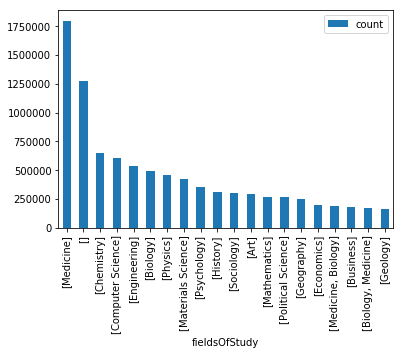

In [155]:
fields_count = spark_df3.groupby('fieldsOfStudy').count().sort('count', ascending = False)
#convert Pyspark dataframe to Pandas dataframe for plotting
pdf = fields_count.toPandas()
pdf[:20].plot(kind= 'bar', x='fieldsOfStudy')
plt.show()

#### Nans by column

In [171]:
# from pyspark.sql.functions import isnan, when, count, col

# spark_df3.select([count(when(isnan(c), c)).alias(c) for c in spark_df3.columns]).show()

# DISTRIBUTION OF inCitations_count

In [176]:
import pandas as pd
import matplotlib.pyplot as plt

# Doing the heavy lifting in Spark. We could leverage the `histogram` function from the RDD api

inCitations_count_histogram = spark_df3.select('inCitations_count').rdd.flatMap(lambda x: x).histogram(11)

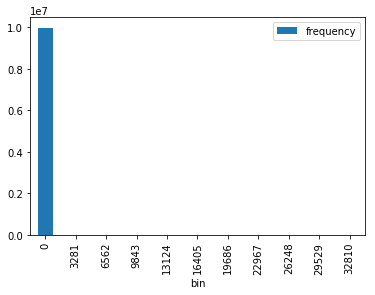

In [175]:
# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*inCitations_count_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar')

In [188]:
from pyspark.sql import functions as F

spark_df3.agg(F.min(spark_df3.inCitations_count),F.max(spark_df3.inCitations_count), \
              F.avg(spark_df3.inCitations_count),F.sum(spark_df3.inCitations_count), \
             F.count(spark_df3.inCitations_count)).show(truncate = False)

+----------------------+----------------------+----------------------+----------------------+------------------------+
|min(inCitations_count)|max(inCitations_count)|avg(inCitations_count)|sum(inCitations_count)|count(inCitations_count)|
+----------------------+----------------------+----------------------+----------------------+------------------------+
|0                     |36091                 |3.5324064204140146    |35242780              |9976989                 |
+----------------------+----------------------+----------------------+----------------------+------------------------+



# APPENDIX

In [ ]:
# from pyspark.sql.functions import udf, col, lower, regexp_replace
# from pyspark.ml.feature import Tokenizer, StopWordsRemover
# from nltk.stem.snowball import SnowballStemmer

# # Clean text
# df_clean = spark_df2.withColumn('title_clean', (lower(regexp_replace('title', "[^a-zA-Z\\s]", "")).alias('title')))

# # Tokenize text
# tokenizer = Tokenizer(inputCol='title_clean', outputCol='title_clean_token')
# df_words_token = tokenizer.transform(df_clean)

# # Remove stop words
# remover = StopWordsRemover(inputCol='title_clean_token', outputCol='title_clean_token_sw')
# df_words_no_stopw = remover.transform(df_words_token)

# # Stem text
# stemmer = SnowballStemmer(language='english')
# stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
# df_stemmed = df_words_no_stopw.withColumn("title_clean_token_stemmed", stemmer_udf("title_clean_token_sw"))

# # Filter length word > 3
# filter_length_udf = udf(lambda row: [x for x in row if len(x) >= 3], ArrayType(StringType()))
# df_final_words = df_stemmed.withColumn('title_complete', filter_length_udf(col('title_clean_token_stemmed')))

#####################################################################################################################
# import nltk
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# from nltk.corpus import stopwords
# import re
# import string
# nltk.download('wordnet')
# stop_words=set(stopwords.words('english'))
# list_punct=list(string.punctuation)
# lemmatizer = WordNetLemmatizer()

# def clean_text(x):
#     filteredSentence = [w for w in x if not w in stop_words]
#     filtered = [''.join(c for c in s if c not in list_punct) for s in filteredSentence] 
#     filtered_space = [s for s in filtered if s] #remove empty space
#     finalLem = [lemmatizer.lemmatize(s) for s in filtered_space]
#     return finalLem

# clean_text_udf = udf(lambda tokens: clean_text(tokens), ArrayType(StringType())) 

#clean_text(spark_df2.limit(1).select('title_tokens').collect()[0][0])

In [162]:
#### ANALYSIS OF JOURNAL NAMES
# spark_df3.groupby('journalName').agg(F.min(spark_df3.inCitations_count),F.max(spark_df3.inCitations_count), \
#               F.avg(spark_df3.inCitations_count),F.sum(spark_df3.inCitations_count), \
#              F.count(spark_df3.inCitations_count)).sort('count(inCitations_count)', ascending = False).show(truncate = False)

# fields_count = spark_df3.groupby('journalName').count().sort('count', ascending = False)
# #convert Pyspark dataframe to Pandas dataframe for plotting
# pdf = fields_count.toPandas()
# pdf[:20].plot(kind= 'bar', x='journalName')
# plt.show()